In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import cv2
import numpy as np

device = torch.device('cuda:0')

/home/chaoqiy2/miniconda3/envs/moltext/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load MNIST Dataset

In [2]:
# for training set, we load the data and label
trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True)
xtrain = trainset.data.numpy()
ytrain = trainset.targets.numpy()

# for test set, we load the data and label
testset = torchvision.datasets.MNIST(root='./data', train = False, download = True)
xtest = testset.data.numpy()
ytest = testset.targets.numpy()

print (xtrain.shape, ytrain.shape)
print (xtest.shape, ytest.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


/home/chaoqiy2/miniconda3/envs/moltext/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630836880/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### get data loader

In [3]:
# transform pixel value (0, 255) into {0,1}
xtrain = np.where(xtrain > 128, 1, 0)
xtrain = xtrain.astype(np.float32)

# transform pixel value (0, 255) into {0,1}
xtest = np.where(xtest > 128, 1, 0)
xtest = xtest.astype(np.float32)

batch_size = 256
trainloader = torch.utils.data.DataLoader([[xtrain[i], ytrain[i]] for i in range(len(ytrain))], \
                                          shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[xtest[i], ytest[i]] for i in range(len(ytest))], \
                                         shuffle=False, batch_size=batch_size)


## 2. Define the VAE Model (unconditioned)

In [33]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
    
        # DNN as encoder
        self.encoder1 = nn.Linear(28*28, 128)
        self.mu = nn.Linear(128, 8)
        self.log_sigma2 = nn.Linear(128, 8)

        # DNN as decoder
        self.decoder1 = nn.Linear(8, 128)
        self.decoder2 = nn.Linear(128, 28*28)
        
    def encoder(self, x):
        h = torch.tanh(self.encoder1(x))
        return self.mu(h), torch.sqrt(torch.exp(self.log_sigma2(h)))
    
    def sampling(self, mu, std): # Reparameterization trick
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        h = torch.tanh(self.decoder1(z))
        return torch.sigmoid(self.decoder2(h)) 
    
    def forward(self, x):
        mu, std = self.encoder(x.view(-1, 28*28))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std
    
    @staticmethod
    def loss_func(x_hat, x, mu, std): 
        # define the reconstruction loss
        ERR = F.binary_cross_entropy(x_hat, x, reduction='sum')
        # define the KL divergence loss
        KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
        return ERR + KLD, ERR, KLD
    
model = VAE()
model.to(device) # move model to GPU

VAE(
  (encoder1): Linear(in_features=784, out_features=128, bias=True)
  (mu): Linear(in_features=128, out_features=8, bias=True)
  (log_sigma2): Linear(in_features=128, out_features=8, bias=True)
  (decoder1): Linear(in_features=8, out_features=128, bias=True)
  (decoder2): Linear(in_features=128, out_features=784, bias=True)
)

## 3. Model Training and Evaluation

In [34]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.002)

rec_loss, kl_loss = [], []
for epoch in range(50):
    
    """ model training """
    model.train()
    cur_rec_loss, cur_kl_loss = [], []
    for batch_idx, (data, _) in enumerate(trainloader):
        data = data.to(device)
        rec, mu, std = model(data)
        loss, err, kl = model.loss_func(rec, data.reshape(-1, 28*28), mu, std)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        cur_rec_loss.append(err.item())
        cur_kl_loss.append(kl.item())
        
    rec_loss.append(np.mean(cur_rec_loss))
    kl_loss.append(np.mean(cur_kl_loss))
    
    """ model evaluation """
    with torch.no_grad():
        test_loss = []
        for batch_idx, (data, _) in enumerate(testloader):
            data = data.to(device)
            rec, mu, std = model(data)
            _, mse, _ = model.loss_func(rec, data.reshape(data.shape[0], -1), mu, std)
            test_loss.append(mse.item())

    if epoch % 10 == 0:
        print (f"-- epoch {epoch} --, train MSE: {np.mean(cur_rec_loss)}, train KL: {np.mean(cur_kl_loss)}, test MSE: {np.mean(test_loss)}")
        
    

-- epoch 0 --, train MSE: 46253.532987034574, train KL: 2965.6796634917564, test MSE: 33957.40220336914
-- epoch 10 --, train MSE: 24715.56885804521, train KL: 4029.8427557762634, test MSE: 24002.60086364746
-- epoch 20 --, train MSE: 23112.449376662233, train KL: 4155.92374709109, test MSE: 22585.853298950195
-- epoch 30 --, train MSE: 22407.728390957447, train KL: 4229.467601500166, test MSE: 22136.877194213866
-- epoch 40 --, train MSE: 21995.03388048537, train KL: 4269.6293924534575, test MSE: 21645.925708007813


## 4. Draw Loss Curve

Text(0.5, 1.0, 'KL divergence loss')

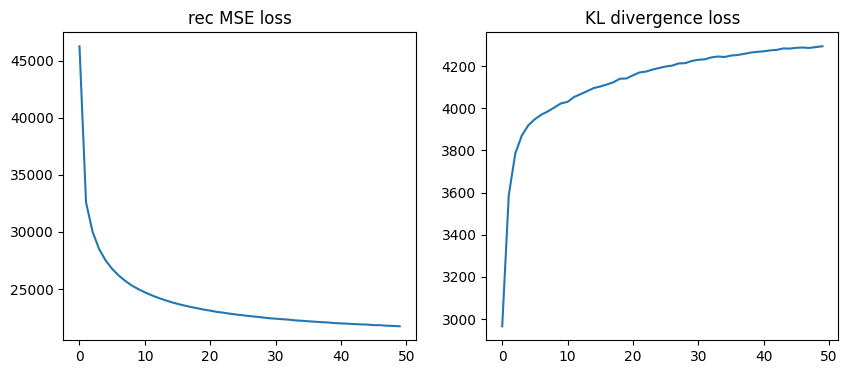

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(rec_loss)
plt.title("rec MSE loss")

plt.subplot(122)
plt.plot(kl_loss)
plt.title("KL divergence loss")

## 5. Generate new data (cannot control with digit)

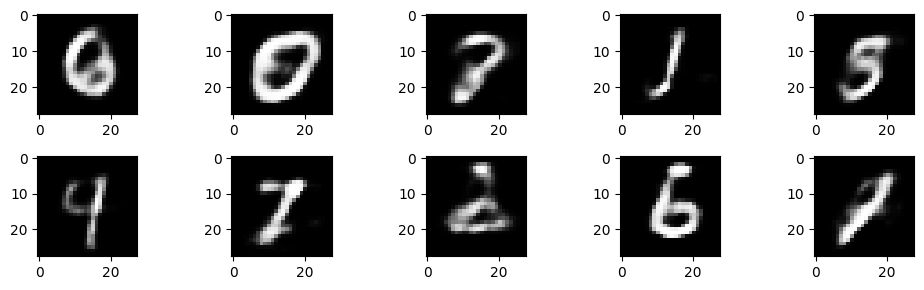

In [36]:
plt.figure(figsize=(10, 3))

model.eval()
with torch.no_grad():
    for l in range(10):
        plt.subplot(2, 5, l+1)
        
        # randomly generate a 8-dim bottleneck vector
        x = np.random.normal(0, 1, 8)
        x = x.astype(np.float32)
        x = torch.from_numpy(x).to(device).unsqueeze(0)

        # use decoder to generate the digit image
        rec = model.decoder(x).detach().cpu().numpy()
        rec = rec.reshape((1, 28, 28))[0]
        plt.imshow(rec, cmap="gray")

plt.tight_layout()
plt.show()

## 6. Try to generate digits with given labels

In [37]:
class ConditionedVAE(nn.Module):
    def __init__(self):
        super(ConditionedVAE, self).__init__()
    
        # for each digit, we learn a 8-dim vector
        self.digit = nn.Embedding(10, 8)
        
        # DNN as encoder
        self.encoder1 = nn.Linear(28*28, 128)
        self.mu = nn.Linear(128, 8)
        self.log_sigma2 = nn.Linear(128, 8)

        # DNN as decoder
        self.decoder1 = nn.Linear(8, 128)
        self.decoder2 = nn.Linear(128, 28*28)
        
    def encoder(self, x):
        h = torch.tanh(self.encoder1(x))
        return self.mu(h), torch.sqrt(torch.exp(self.log_sigma2(h)))
    
    def sampling(self, mu, std): # Reparameterization trick
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z, l):
        z = z + self.digit(l)
        h = torch.tanh(self.decoder1(z))
        return torch.sigmoid(self.decoder2(h)) 
    
    def forward(self, x, l):
        mu, std = self.encoder(x.view(-1, 28*28))
        z1 = self.sampling(mu, std)
        z2 = self.sampling(mu, std)
        z = (z1 +z2) / 2
        return self.decoder(z, l), mu, std
    
    @staticmethod
    def loss_func(x_hat, x, mu, std): 
        # define the reconstruction loss
        ERR = F.binary_cross_entropy(x_hat, x, reduction='sum')
        # define the KL divergence loss
        KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
        return ERR + KLD, ERR, KLD
    
model = ConditionedVAE()
model.to(device) # move model to GPU

ConditionedVAE(
  (digit): Embedding(10, 8)
  (encoder1): Linear(in_features=784, out_features=128, bias=True)
  (mu): Linear(in_features=128, out_features=8, bias=True)
  (log_sigma2): Linear(in_features=128, out_features=8, bias=True)
  (decoder1): Linear(in_features=8, out_features=128, bias=True)
  (decoder2): Linear(in_features=128, out_features=784, bias=True)
)

In [73]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)

rec_loss, kl_loss = [], []
for epoch in range(50):
    
    """ model training """
    model.train()
    cur_rec_loss, cur_kl_loss = [], []
    for batch_idx, (data, label) in enumerate(trainloader):
        data = data.to(device)
        label = label.to(device)
        rec, mu, std = model(data, label)
        loss, err, kl = model.loss_func(rec, data.reshape(-1, 28*28), mu, std)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        cur_rec_loss.append(err.item())
        cur_kl_loss.append(kl.item())
        
    rec_loss.append(np.mean(cur_rec_loss))
    kl_loss.append(np.mean(cur_kl_loss))
    
    """ model evaluation """
    with torch.no_grad():
        test_loss = []
        for batch_idx, (data, label) in enumerate(testloader):
            data = data.to(device)
            label = label.to(device)
            rec, mu, std = model(data, label)
            _, mse, _ = model.loss_func(rec, data.reshape(data.shape[0], -1), mu, std)
            test_loss.append(mse.item())

    if epoch % 10 == 0:
        print (f"-- epoch {epoch} --, train MSE: {np.mean(cur_rec_loss)}, train KL: {np.mean(cur_kl_loss)}, test MSE: {np.mean(test_loss)}")
        
    

-- epoch 0 --, train MSE: 21091.236201379656, train KL: 3308.4039498836437, test MSE: 21157.176983642577
-- epoch 10 --, train MSE: 20999.04569481383, train KL: 3317.5221440741357, test MSE: 21059.00046386719
-- epoch 20 --, train MSE: 20934.905516539227, train KL: 3325.0378843916224, test MSE: 20998.86536254883
-- epoch 30 --, train MSE: 20884.33543882979, train KL: 3326.6405564328456, test MSE: 21035.790444946288
-- epoch 40 --, train MSE: 20837.269200880983, train KL: 3329.8353203956117, test MSE: 20945.185528564452


## 7. Generate new data (could control with digit)

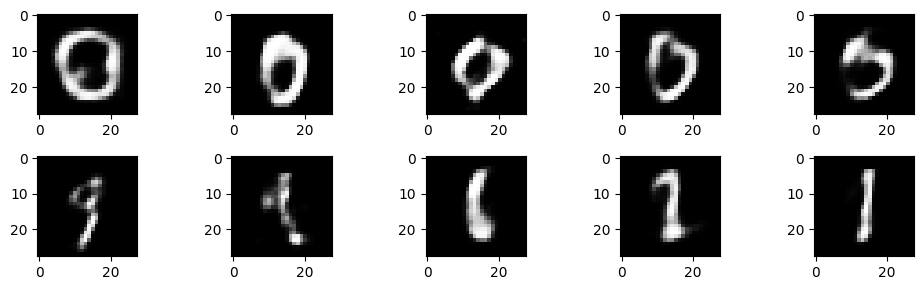

In [86]:
plt.figure(figsize=(10, 3))

model.eval()
with torch.no_grad():
    for idx, l in enumerate([0 for i in range(5)] + [1 for i in range(5)]):
        plt.subplot(2, 5, idx+1)
        
        # randomly generate a 8-dim bottleneck vector
        x = np.random.normal(0, 1, 8)
        x = x.astype(np.float32)
        x = torch.from_numpy(x).to(device).unsqueeze(0)
        l = torch.LongTensor([l]).to(device).unsqueeze(0)

        # use decoder to generate the digit image
        rec = model.decoder(x, l).detach().cpu().numpy()
        rec = rec.reshape((1, 28, 28))[0]
        plt.imshow(rec, cmap="gray")

plt.tight_layout()
plt.show()

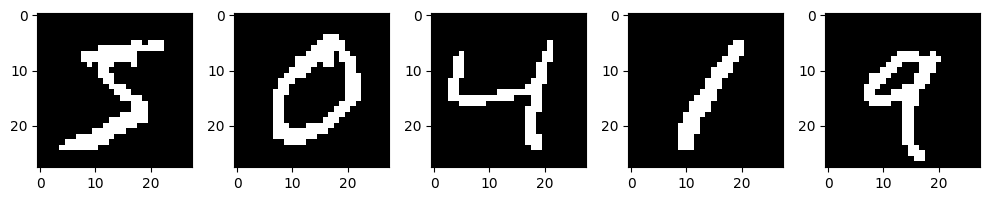

In [31]:
plt.figure(figsize=(10, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(xtrain[i], cmap="gray")

plt.tight_layout()